## Using a ML policy in Navground

We have see how to embed navground agents in Gymnasium and PettingZoo.

This notebook shows how to do the opposite, i.e., how to use a ML policy in navground. 

Let us reload the same configuration and saved (random) policy as in [the Gymnasium notebook](Gymnasium.ipynb).

In [1]:
from navground import sim

with open('scenario.yaml') as f:
    scenario = sim.load_scenario(f.read())

with open('sensor.yaml') as f:
    sensor = sim.load_state_estimation(f.read())

In [2]:
from navground.learning import DefaultObservationConfig, ControlActionConfig

observation_config = DefaultObservationConfig(include_target_direction=True, 
                                              include_target_distance=True)
action_config = ControlActionConfig()

We load the random policy we exported to onnx

In [3]:
from navground.learning.onnx import OnnxPolicy

policy = OnnxPolicy("policy.onnx")

`PolicyBehavior` wraps the policy as a navground `core.Behavior` which can be assigned to an agent.

In [4]:
from navground.learning.behaviors import PolicyBehavior

world = scenario.make_world(seed=101)
agent = world.agents[0]
agent.behavior = PolicyBehavior.clone_behavior(
    agent.behavior, policy=policy, action_config=action_config, observation_config=observation_config)
agent.state_estimation = sensor
agent.color = 'red'

As an alternative, instead of using Python, we can load the modified scenario directly from YAML

In [5]:
%%writefile scenario_with_policy.yaml
type: Cross
agent_margin: 0.1
side: 4
target_margin: 0.1
tolerance: 0.5
groups:
  -
    type: thymio
    number: 1
    radius: 0.1
    control_period: 0.1
    speed_tolerance: 0.02
    color: red
    kinematics:
      type: 2WDiff
      wheel_axis: 0.094
      max_speed: 0.12
    behavior:
      type: Policy
      include_target_direction: true
      include_target_distance: true
      policy_path: policy.onnx
    state_estimation:
      type: Discs
      number: 5
      range: 5.0
      max_speed: 0.12
      max_radius: 0.1
  -
    type: thymio
    number: 19
    radius: 0.1
    control_period: 0.1
    speed_tolerance: 0.02
    color: gray
    kinematics:
      type: 2WDiff
      wheel_axis: 0.094
      max_speed: 0.12
    behavior:
      type: HL
      optimal_speed: 0.12
      horizon: 5.0
      tau: 0.25
      eta: 0.5
      safety_margin: 0.1
    state_estimation:
      type: Bounded
      range: 5.0

Overwriting scenario_with_policy.yaml


In [6]:
with open('scenario_with_policy.yaml') as f:
    scenario_with_policy = sim.load_scenario(f.read())

world = scenario_with_policy.make_world(seed=101)

We can now use any tool available in naground to run the simulation.

For instance, to display a video

In [7]:
from navground.sim.ui.video import display_video

display_video(world, time_step=0.1, duration=60.0, factor=10.0, 
              display_width=400, width=400)

or record data

In [8]:
from navground.learning.probes import RewardProbe
from navground.learning.rewards import SocialReward

run = sim.ExperimentalRun(world, time_step=0.1, steps=1200, record_config=sim.RecordConfig.all(True))
# we record the reward for all agents
probe = RewardProbe.with_reward(SocialReward())
run.add_record_probe("reward", probe)
run.run()

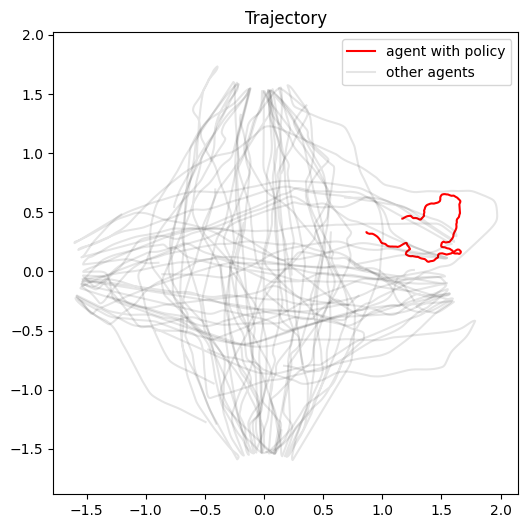

In [9]:
from matplotlib import pyplot as plt

plt.figure(figsize=(6, 6))
for i in range(run.poses.shape[1]):
    xs, ys = run.poses[:, i, :2].T
    if i == 0:
        plt.plot(xs, ys, 'r', label="agent with policy")
    elif i == 1:
        plt.plot(xs, ys, 'k', alpha=0.1, label="other agents")
    else:
        plt.plot(xs, ys, 'k', alpha=0.1)
plt.axis('equal');
plt.legend()
plt.title('Trajectory');

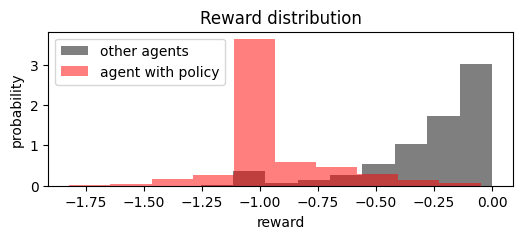

In [10]:
import numpy as np

rewards = np.asarray(run.records["reward"])
plt.figure(figsize=(6, 2))
plt.hist(rewards[:, 1:].flatten(), density=True, color='black', alpha=0.5, label="other agents")
plt.hist(rewards[:, 0], density=True, color='red', alpha=0.5, label="agent with policy");
plt.legend()
plt.xlabel("reward")
plt.ylabel("probability")
plt.title('Reward distribution');

Similarly, we can increase the number of agents using the policy, from YAML, or 

In [11]:
world = scenario.make_world(seed=101)
for agent in world.agents:
    agent.behavior = PolicyBehavior.clone_behavior(
        agent.behavior, policy=policy, action_config=action_config, observation_config=observation_config)
    agent.state_estimation = sensor
    agent.color = 'red'

display_video(world, time_step=0.1, duration=60.0, factor=10.0, display_width=400, width=400)

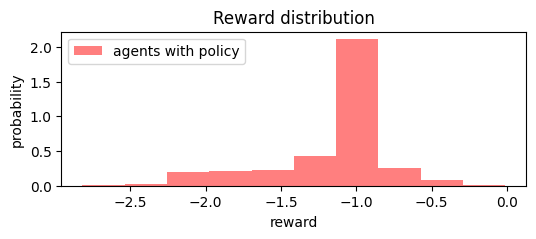

In [12]:
run = sim.ExperimentalRun(world, time_step=0.1, steps=1200, record_config=sim.RecordConfig.all(True))
run.add_record_probe("reward", probe)
run.run()

rewards = np.asarray(run.records["reward"])
plt.figure(figsize=(6, 2))
plt.hist(rewards.flatten(), density=True, color='red', alpha=0.5, label="agents with policy");
plt.legend()
plt.xlabel("reward")
plt.ylabel("probability")
plt.title('Reward distribution');